<div style="border-left:6px solid #6366F1; padding:12px 14px; border-radius:10px;">

# BAföG OCEL Simulation

<span style="display:inline-block; padding:2px 10px; border-radius:999px; border:1px solid currentColor; font-size:12px;">OCEL</span>
<span style="display:inline-block; padding:2px 10px; border-radius:999px; border:1px solid currentColor; font-size:12px;">SimPy</span>
<span style="display:inline-block; padding:2px 10px; border-radius:999px; border:1px solid currentColor; font-size:12px;">CSV Export</span>

This notebook generates a **synthetic OCEL (Object-Centric Event Log)** for the BAföG application process.

### Flow
1. **Load config** from `data/bpmn_models/simulation_config/sim_ocel_config.json`
2. **Simulate arrivals** with time-dependent inter-arrival rates
3. **Simulate process behavior** (gateways, deviations, durations)
4. **Model capacity / backlog** using a limited **SimPy resource** for `Clerk`

### Key concepts
- **System** activities have *unlimited capacity (24/7)*.
- **Clerk** activities are capacity-limited (queues/backlogs can occur).

### Data model
Based on `agent/schema.sql` with two object types:
- **Application**: every activity is linked to this object.
- **Document**: 1–5 documents per application (depending on attributes).

### Outputs
- `events.csv` – all events with sorting column
- `applications.csv` – application objects
- `documents.csv` – document objects
- `event_object_link.csv` – links between events and objects
- `log_not_sliced.csv` – intermediate control file

Further parameter details and assumptions: [bafoeg_params_report.pdf](agent/params_report/bafoeg_params_report.pdf)

</div>

## 1. Setup & Imports

In [11]:
import json
import random
from datetime import datetime, timedelta
from dataclasses import dataclass, field
from typing import List, Dict, Optional, Tuple
from pathlib import Path
import numpy as np
import pandas as pd
import simpy
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve().parent   # notebooks/ -> project/
sys.path.insert(0, str(PROJECT_ROOT))

from config import ROOT, OCEL_SIMULATION_DIR, OCEL_DIR
# Project paths

print(f"Project Root: {ROOT}")
print(f"Config Path: {OCEL_SIMULATION_DIR}")
print(f"Output Dir: {OCEL_DIR}")

Project Root: /Users/davidderr/Desktop/pm4py-bpmn-simulation
Config Path: /Users/davidderr/Desktop/pm4py-bpmn-simulation/data/bpmn_models/simulation_config/sim_ocel_config.json
Output Dir: /Users/davidderr/Desktop/pm4py-bpmn-simulation/data/outputs/event_logs/ocel


## 2. Load Configuration

<div style="border-left:6px solid #22C55E; padding:12px 14px; border-radius:10px;">

## Simulation Configuration (`sim_ocel_config.json`)

### Most important fields under `simulation`

- `num_cases`
  Total number of applications to generate.
- `start_date`
  Timestamp of simulation start.
- `random_seed`
  Makes the simulation reproducible.

### Time span control

- `target_log_days`
  Target overall time span (days) for generated timestamps.
- `tail_buffer_days`
  Extra days after the *last arrival* so in-flight cases can finish (realistic tail).

### Realism / backlog controls

- `enforce_working_hours`
  If `true`, `Clerk` work is restricted to `resources.Clerk.availability`.
- `max_review_rounds`
  Upper bound for repeating the "Review → missing? → request/receive" cycle.

### Optional boundary events

- `include_start_event` → include/exclude `Application started`
- `include_end_event` → include/exclude `Application handled`

### Arrivals
Arrivals are configured under `interarrival` (weekday/weekend + hour-of-day mean minutes). The notebook calibrates these means by applying an internal scale factor so arrivals fit into `target_log_days`.

</div>

In [12]:
with open(OCEL_SIMULATION_DIR, 'r', encoding='utf-8') as f:
    config = json.load(f)

# ==================================================================================
# CONFIGURATION SANITY CHECK
# ==================================================================================
print("\nAPPLYING CONFIGURATION OVERRIDES FOR HIGH LOAD SCENARIO")

# 1. Resources
if 'resources' not in config: config['resources'] = {}
if 'Clerk' not in config['resources']: config['resources']['Clerk'] = {}
print(f"  - Clerk capacity set to {config['resources']['Clerk']['capacity']}")

# 2. Arrival Rate
# Set all inter-arrival means to 15 minutes
if 'interarrival' in config:
    for key, val in config['interarrival'].items():
        if 'mean_minutes' in val:
            print(f"  - Inter-arrival mean set to {val['mean_minutes']} minutes for {key}")

# 3. Fix Waiting Times & Stress Activity
if 'activities' not in config: config['activities'] = {}

# ==================================================================================
# Extract key parameters
NUM_CASES = config['simulation']['num_cases']
START_DATE = datetime.fromisoformat(config['simulation']['start_date'])
RANDOM_SEED = config['simulation']['random_seed']
TARGET_LOG_DAYS = config.get('simulation', {}).get('target_log_days', 150)

# Debug mode: Set to True for faster testing with fewer cases
DEBUG_MODE = False
DEBUG_CASES = 50  # Number of cases in debug mode

if DEBUG_MODE:
    NUM_CASES = DEBUG_CASES
    print(f"⚠️  DEBUG MODE: Running with {NUM_CASES} cases")

# Set random seeds
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"Simulation: {NUM_CASES} cases starting at {START_DATE}")
print(f"Random seed: {RANDOM_SEED}")
print(f"Target time span (days): {TARGET_LOG_DAYS}")



APPLYING CONFIGURATION OVERRIDES FOR HIGH LOAD SCENARIO
  - Clerk capacity set to 32
  - Inter-arrival mean set to 1.5 minutes for weekday_08_16
  - Inter-arrival mean set to 2.7 minutes for weekday_16_21
  - Inter-arrival mean set to 8.1 minutes for weekday_21_24
  - Inter-arrival mean set to 10.8 minutes for weekend
Simulation: 9800 cases starting at 2024-09-01 00:00:00
Random seed: 42
Target time span (days): 150


## 3. Data Classes

<div style="border-left:6px solid #A855F7; padding:12px 14px; border-radius:10px;">

### Data classes (OCEL objects + events)

<span style="display:inline-block; padding:2px 10px; border-radius:999px; border:1px solid currentColor; font-size:12px;">Application</span>
<span style="display:inline-block; padding:2px 10px; border-radius:999px; border:1px solid currentColor; font-size:12px;">Document</span>
<span style="display:inline-block; padding:2px 10px; border-radius:999px; border:1px solid currentColor; font-size:12px;">Event</span>

This section defines the core in-memory structures that later become the OCEL tables:

- **`Application`**
  The primary business object (case/object), with attributes like `is_parent_independent`, `housing_type`, and final `status`.
- **`Document`**
  Secondary object type linked to an application (`application_id`). Documents can be `Missing` or `Received`, with an optional `submission_date`.
- **`Event`**
  Stores one activity execution with `activity`, `timestamp`, and `org_resource` and a list of `linked_objects`.

Each class provides a `to_dict()` used during export to build the CSV files.

</div>

In [13]:
@dataclass
class Application:
    """Represents a BAföG application."""
    application_id: str
    student_id: str
    is_initial_application: bool = True
    is_parent_independent: bool = False
    housing_type: str = "Alleine"  # 'Eltern' or 'Alleine'
    status: str = "Pending"  # 'Pending', 'Approved', 'Rejected'
    deviation_type: Optional[str] = None  # None, 'Switched', 'Shortened', 'Timeout'
    
    def to_dict(self) -> dict:
        return {
            'application_id': self.application_id,
            'student_id': self.student_id,
            'is_initial_application': self.is_initial_application,
            'is_parent_independent': self.is_parent_independent,
            'housing_type': self.housing_type,
            'status': self.status,
            'deviation_type': self.deviation_type
        }


@dataclass
class Document:
    """Represents a document attached to an application."""
    document_id: str
    application_id: str
    doc_type: str
    doc_category: str
    status: str = "Missing"  # 'Missing', 'Received'
    submission_time: Optional[float] = None
    reviewed: bool = False  # Added to track if document has been reviewed
    printed: bool = False
    archived: bool = False
    
    def to_dict(self, start_date: datetime) -> dict:
        submission_str = None
        if self.submission_time is not None:
            ts = start_date + timedelta(minutes=self.submission_time)
            submission_str = ts.strftime('%Y-%m-%d %H:%M:%S')

        return {
            'document_id': self.document_id,
            'application_id': self.application_id,
            'doc_type': self.doc_type,
            'doc_category': self.doc_category,
            'status': self.status,
            'submission_date': submission_str,
            'reviewed': self.reviewed,
            'printed': self.printed,
            'archived': self.archived
        }


@dataclass
class Event:
    """Represents an event in the process."""
    event_id: str
    activity: str
    sim_time: float
    sorting_integer: int
    org_resource: str
    linked_objects: List[Tuple[str, str]] = field(default_factory=list)  # [(object_id, object_type), ...]
    case_id: str = ""  # Added for compatibility
    
    def to_dict(self, start_date: datetime) -> dict:
        ts = start_date + timedelta(minutes=self.sim_time)
        return {
            'event_id': self.event_id,
            'case_id': self.case_id,
            'activity': self.activity,
            'timestamp': ts.strftime('%Y-%m-%d %H:%M:%S'),
            'sorting_integer': self.sorting_integer,
            'org_resource': self.org_resource
        }

## 4. Duration Sampling Functions

<div style="border-left:6px solid #06B6D4; padding:12px 14px; border-radius:10px;">

### Duration sampling (activity processing times)

<span style="display:inline-block; padding:2px 10px; border-radius:999px; border:1px solid currentColor; font-size:12px;">uniform</span>
<span style="display:inline-block; padding:2px 10px; border-radius:999px; border:1px solid currentColor; font-size:12px;">normal</span>
<span style="display:inline-block; padding:2px 10px; border-radius:999px; border:1px solid currentColor; font-size:12px;">exponential</span>

This section turns the JSON activity definitions into sampled **durations in minutes**.

- `sample_duration(activity_config)`
  Samples from the configured distribution and applies bounds (min/max) to avoid unrealistic outliers.
- `get_activity_duration(activity_name)`
  Looks up the activity in `config['activities']` (exact match first, then partial match) and returns a sampled duration.
- `get_resource(activity_name)`
  Returns the configured resource (e.g., `System` or `Clerk`) for the activity.

These durations feed directly into SimPy timeouts and therefore shape the timestamp spacing in the final event log.

</div>

In [14]:
def sample_duration(activity_config: dict) -> float:
    """Sample a duration in minutes based on the activity configuration."""
    dist = activity_config.get('distribution', 'uniform')
    
    if dist == 'uniform':
        duration = random.uniform(
            activity_config.get('min_minutes', 1),
            activity_config.get('max_minutes', 5)
        )
    
    elif dist == 'normal':
        mean = activity_config.get('mean_minutes', 10)
        std = activity_config.get('std_minutes', 2)
        min_val = activity_config.get('min_minutes', 1)
        max_val = activity_config.get('max_minutes', mean * 3)
        
        duration = np.random.normal(mean, std)
        duration = max(min_val, min(max_val, duration))  # Truncate
    
    elif dist == 'exponential':
        mean = activity_config.get('mean_minutes', 60)
        min_val = activity_config.get('min_minutes', 1)
        max_val = activity_config.get('max_minutes', mean * 3)
        
        duration = np.random.exponential(mean)
        duration = max(min_val, min(max_val, duration))  # Truncate
        
    else:
        print(f"⚠️  Warning: sample_duration '{activity_config}' not found in config. Using default duration.")
        duration = 5  # Default    
    return duration


def get_activity_duration(activity_name: str) -> float:
    """Get duration for an activity in minutes."""
    activities = config.get('activities', {})
    
    # Try exact match first
    if activity_name in activities:
        return sample_duration(activities[activity_name])
    
    # Try partial match
    for key, cfg in activities.items():
        if key.lower() in activity_name.lower() or activity_name.lower() in key.lower():
            return sample_duration(cfg)
    
    # Default: 5 minutes
    print(f"⚠️  Warning: Activity '{activity_name}' not found in config. Using default duration.")
    return 5.0


def get_resource(activity_name: str) -> str:
    """Get resource for an activity."""
    activities = config.get('activities', {})
    if activity_name in activities:
        return activities[activity_name].get('resource', 'System')
    return 'System'

## 5. Document Generation

<div style="border-left:6px solid #F97316; padding:12px 14px; border-radius:10px;">

### Document generation (object creation rules)

<span style="display:inline-block; padding:2px 10px; border-radius:999px; border:1px solid currentColor; font-size:12px;">conditions</span>
<span style="display:inline-block; padding:2px 10px; border-radius:999px; border:1px solid currentColor; font-size:12px;">1..N docs</span>

This section generates `Document` objects for each `Application` based on attributes and JSON rules in `config['document_types']`.

- Documents with `always_generated: true` are created for every application.
- Conditional documents are created depending on application attributes, e.g.:
  - parent-dependent applications generate income-related forms
  - students not living with parents can generate housing documents

New documents start with status `Missing` and are later set to `Received` when the simulation reaches the corresponding receive step.

</div>

In [15]:
def generate_documents(application: Application, doc_counter: int) -> Tuple[List[Document], int]:
    """Generate documents for an application based on its attributes."""
    documents = []
    doc_types = config.get('document_types', {})
    
    for doc_type, doc_config in doc_types.items():
        should_generate = False
        
        if doc_config.get('always_generated', False):
            should_generate = True
            
        elif doc_config.get('condition') == 'is_parent_dependent':
            should_generate = not application.is_parent_independent
        elif doc_config.get('condition') == 'has_formblatt_3':
            # Check if Formblatt 3 was generated
            should_generate = not application.is_parent_independent
            
        elif doc_config.get('condition') == 'not_living_with_parents':
            should_generate = application.housing_type != 'Eltern'
        
        if should_generate:
            doc = Document(
                document_id=f"DOC_{doc_counter:06d}",
                application_id=application.application_id,
                doc_type=doc_type,
                doc_category=doc_config.get('category', 'Sonstiges'),
                status='Missing'
            )
            documents.append(doc)
            doc_counter += 1
    
    return documents, doc_counter


# Test document generation
test_app = Application(
    application_id="APP_TEST",
    student_id="STU_TEST",
    # TODO: Change to is_parent_dependent for better understanding
    is_parent_independent=False,
    housing_type="Alleine"
)

test_docs, _ = generate_documents(test_app, 0)
print(f"Test application generates {len(test_docs)} documents:")
for doc in test_docs:
    print(f"  - {doc.doc_type} ({doc.doc_category})")

Test application generates 5 documents:
  - Formblatt 1 (Student)
  - Immatrikulationsbescheinigung (Student)
  - Formblatt 3 (Eltern)
  - Einkommensnachweis Eltern (Eltern)
  - Mietbescheinigung (Student)


## 6. Simulation Engine

<div style="border-left:6px solid #F59E0B; padding:12px 14px; border-radius:10px;">

### Simulation engine details

<span style="display:inline-block; padding:2px 10px; border-radius:999px; border:1px solid currentColor; font-size:12px;">Queues</span>
<span style="display:inline-block; padding:2px 10px; border-radius:999px; border:1px solid currentColor; font-size:12px;">Capacity</span>
<span style="display:inline-block; padding:2px 10px; border-radius:999px; border:1px solid currentColor; font-size:12px;">Working Hours</span>

This section implements the process dynamics using **SimPy**.

---

#### Resources and backlogs

- `System` activities run with effectively unlimited capacity and can happen at any time.
- `Clerk` activities use a limited SimPy resource:
  - `self.clerk = simpy.Resource(..., capacity=resources.Clerk.capacity)`
  - If demand > capacity, cases wait in the clerk queue.
  - Waiting times are stored in `sim.waiting_times_minutes['Clerk']`.

---

#### Working hours (optional)

If `simulation.enforce_working_hours = true`, clerk work is only performed during:

- `resources.Clerk.availability.days`
- `resources.Clerk.availability.start_hour` / `end_hour`

Implementation note: before requesting the clerk, the simulation waits until the next shift start (`_minutes_until_next_clerk_shift`).

---

#### Review rounds (controlled)

Bounded by `simulation.max_review_rounds`:

- `1`: at most one review round
- `> 1`: repeat up to N rounds

---

#### Optional start/end events

- `simulation.include_start_event` → `Application started`
- `simulation.include_end_event` → `Application handled`

These switches only affect the event log output, not the internal case objects.

</div>

In [ ]:
class BAfoegSimulation:
    """SimPy-based simulation of the BAföG application process."""
    
    def __init__(self, config: dict, start_date: datetime, interarrival_scale: float = 1.0):
        self.config = config
        self.start_date = start_date
        self.interarrival_scale = interarrival_scale
        self.env = simpy.Environment()

        sim_cfg = config.get('simulation', {})
        self.enforce_working_hours = sim_cfg.get('enforce_working_hours', True)
        self.max_review_rounds = int(sim_cfg.get('max_review_rounds', 5))

        self.include_start_event = bool(sim_cfg.get('include_start_event', True))
        self.include_end_event = bool(sim_cfg.get('include_end_event', True))
        
        # Counters
        self.event_counter = 0
        self.app_counter = 0
        self.doc_counter = 0
        self.case_event_counters: Dict[str, int] = {}
        
        # Storage
        self.applications: List[Application] = []
        self.documents: List[Document] = []
        self.events: List[Event] = []

        # Waiting time stats
        self.waiting_times_minutes: Dict[str, List[float]] = {"Clerk": [], "System": []}
        
        # Gateway probabilities
        self.gateways = config.get('gateways', {})
        
        # Deviation probabilities
        self.deviations = config.get('deviations', {})

        # SimPy resources
        resources_cfg = config.get('resources', {})
        clerk_capacity = int(resources_cfg.get('Clerk', {}).get('capacity', 32))
        
        self.clerk = simpy.Resource(self.env, capacity=clerk_capacity)
        self.resources_cfg = resources_cfg
    
    def sim_time_to_datetime(self, sim_time: float) -> datetime:
        """Convert simulation time (in minutes) to datetime."""
        return self.start_date + timedelta(minutes=sim_time)

    def record_event(self, activity: str, linked_objects: List[Tuple[str, str]], resource: str = None):
        """Record an event."""
        self.event_counter += 1
        
        if resource is None:
            resource = get_resource(activity)
        
        # Extract case_id from linked_objects (find 'Application' type)
        case_id = ""
        for obj_id, obj_type in linked_objects:
            if obj_type == 'Application':
                case_id = obj_id
                break

        # Increment per-case counter for sorting_integer (Celonis requirement)
        if case_id:
            if case_id not in self.case_event_counters:
                self.case_event_counters[case_id] = 0
            self.case_event_counters[case_id] += 1
            sorting_int = self.case_event_counters[case_id]
        else:
            sorting_int = self.event_counter

        event = Event(
            event_id=f"E_{self.event_counter:06d}",
            activity=activity,
            sim_time=self.env.now,
            sorting_integer=sorting_int,
            org_resource=resource,
            linked_objects=linked_objects,
            case_id=case_id
        )
        self.events.append(event)
        return event

    def decide_gateway(self, gateway_name: str, option_a: str, option_b: str) -> str:
        """Make a gateway decision based on probabilities."""
        gateway_config = self.gateways.get(gateway_name, {})
        prob_a = gateway_config.get(option_a, 0.5)

        return option_a if random.random() < prob_a else option_b

    def check_deviation(self, deviation_name: str) -> bool:
        """Check if a deviation should occur."""
        deviation_config = self.deviations.get(deviation_name, {})
        prob = deviation_config.get('probability', 0.0)
        return random.random() < prob
    
    def get_timeout_days(self) -> int:
        """Get timeout threshold in days from config."""
        timeout_cfg = self.deviations.get('document_timeout', {})
        return timeout_cfg.get('timeout_days', 30)

    def _minutes_until_next_clerk_shift(self) -> float:
        if not self.enforce_working_hours:
            return 0.0

        clerk_cfg = self.resources_cfg.get('Clerk', {}).get('availability', {})
        days_allowed = set(clerk_cfg.get('days', ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']))
        start_hour = float(clerk_cfg.get('start_hour', 7.5))
        end_hour = float(clerk_cfg.get('end_hour', 16.0))

        now_dt = self.sim_time_to_datetime(self.env.now)

        # Already during a shift?
        if now_dt.strftime('%a') in days_allowed:
            hour = now_dt.hour + now_dt.minute / 60 + now_dt.second / 3600
            if start_hour <= hour < end_hour:
                return 0.0

        # Find next shift start
        for add_days in range(0, 28):
            candidate_day = (now_dt + timedelta(days=add_days)).replace(hour=0, minute=0, second=0, microsecond=0)
            if candidate_day.strftime('%a') not in days_allowed:
                continue

            shift_start = candidate_day + timedelta(hours=start_hour)
            if add_days == 0 and shift_start <= now_dt:
                continue

            return (shift_start - now_dt).total_seconds() / 60

        return 24 * 60

    def perform_activity(self, activity: str, linked_objects: List[Tuple[str, str]], resource: str = None):
        if resource is None:
            resource = get_resource(activity)

        duration = get_activity_duration(activity)

        if resource == 'Clerk':
            pre_wait = self._minutes_until_next_clerk_shift()
            if pre_wait > 0:
                yield self.env.timeout(pre_wait)

            request_start = self.env.now
            with self.clerk.request() as req:
                yield req
                queue_wait = self.env.now - request_start
                self.waiting_times_minutes['Clerk'].append(queue_wait)

                yield self.env.timeout(duration)
                self.record_event(activity, linked_objects, 'Clerk')

        else:
            self.waiting_times_minutes['System'].append(0.0)
            yield self.env.timeout(duration)
            self.record_event(activity, linked_objects, resource)

    def process_application(self, app_id: int):
        # 1. Setup & Object Creation
        is_parent_independent = self.decide_gateway('parent_data_required', 'not_required', 'required') == 'not_required'
        housing_type = self.decide_gateway('housing_situation', 'Alleine', 'Eltern')
        
        # Determine Deviation from config
        # CLEANER DEVIATION SELECTION using weights
        p_shortened = self.deviations.get('direct_rejection', {}).get('probability', 0.05)
        p_switched = self.deviations.get('activity_switch', {}).get('probability', 0.10)
        p_timeout = self.deviations.get('document_timeout', {}).get('probability', 0.04)
        p_blind = self.deviations.get('blind_approval', {}).get('probability', 0.03)
        
        # Calculate remaining probability for the "Happy Path" (None)
        p_none = 1.0 - (p_shortened + p_switched + p_timeout + p_blind)
        
        if p_none < 0:
            print("⚠️ Warning: Deviation probabilities sum > 1.0! Adjust config.")
            p_none = 0

        options = ["Shortened", "Switched", "Timeout", "Blind_Approval", "None"]
        weights = [p_shortened, p_switched, p_timeout, p_blind, p_none]
        
        deviation = random.choices(options, weights=weights, k=1)[0]

        application = Application(
            application_id=f"APP_{app_id:06d}", 
            student_id=f"STU_{app_id:06d}", 
            is_initial_application=True, 
            is_parent_independent=is_parent_independent, 
            housing_type=housing_type, 
            status="Pending",
            deviation_type=deviation
        )
        self.applications.append(application)
        
        # Generate Docs
        documents, self.doc_counter = generate_documents(application, self.doc_counter)
        self.documents.extend(documents)
        
        # --- NEUE LOGIK: Simulieren von vergessenen Dokumenten ---
        # Wir bestimmen hier einmalig, welche Dokumente der Student initial tatsächlich mitschickt.
        docs_provided_initially = set()
        doc_types_cfg = self.config.get('document_types', {})
        
        for d in documents:
            # Check config for mandatory flag
            doc_cfg = doc_types_cfg.get(d.doc_type, {})
            is_mandatory = doc_cfg.get('system_mandatory', False)
            
            if is_mandatory:
                docs_provided_initially.add(d.document_id)
            elif d.doc_category == "Student":
                # Andere Dokumente (Mietvertrag etc.) können fehlen (15% Chance)
                if random.random() < 0.85:
                    docs_provided_initially.add(d.document_id)
        # ---------------------------------------------------------
        
        def app_link(): return [(application.application_id, 'Application')]

        # 2. Start & Ingest
        if self.include_start_event: 
            # Update status for provided docs
            for d in documents:
                if d.document_id in docs_provided_initially:
                    d.status = "Received"
                    d.submission_time = self.env.now
                else:
                    d.status = "Missing"
            
            # Create links: Application + ALL generated documents (received AND missing)
            doc_links = [(d.document_id, 'Document') for d in documents]
            
            # Record ONE start event with ALL links
            self.record_event("Application started", app_link() + doc_links, "System")

        
        # Parent Data Loop (Wait 7 days if needed)
        if not is_parent_independent:
            # Identify parent docs
            parent_docs = [d for d in documents if "Eltern" in d.doc_type]
            
            # Link parent docs to Request
            yield from self.perform_activity("Request Parent Data", app_link() + [(d.document_id, 'Document') for d in parent_docs], "System")
            
            if deviation == "Timeout":
                yield self.env.timeout(30 * 24 * 60)
                yield from self.perform_activity("Send Rejection", app_link(), "Clerk")
                application.status = "Rejected"
                if self.include_end_event:
                    yield self.env.timeout(5)
                    self.record_event("Application handled", app_link())
                return

            # Normaler Ablauf: Warte auf Eingang (~7 Tage)
            yield self.env.timeout(get_activity_duration("Receive Parent Data")) # ~7 days
            
            # Update Parent Docs to Received
            for d in parent_docs: 
                d.status = "Received"
                d.submission_time = self.env.now
            
            # Log Event only for parent docs
            self.record_event("Receive Parent Data", app_link() + [(d.document_id, 'Document') for d in parent_docs], "System")

        yield from self.perform_activity("Send Application Mail", app_link(), "System")
    
        # Main Receipt
        yield self.env.timeout(get_activity_duration("Receive Application"))
        
        
        received_docs = [d for d in documents if d.status == "Received"]
        self.record_event("Receive Application", app_link() + [(d.document_id, 'Document') for d in received_docs], "System")

        # 3. Review Loop (The OCPM Part)
        if deviation == "Shortened":
            yield from self.perform_activity("Send Rejection", app_link(), "Clerk")
            application.status = "Rejected"
            if self.include_end_event:
                yield self.env.timeout(5)
                self.record_event("Application handled", app_link())
            return

        rounds = 0
        while rounds < self.max_review_rounds:
            rounds += 1
            
            # 1. Review Documents (Always happens first in the loop)
            # Identify documents that are ready for review (Received but not yet Reviewed)
            docs_to_review = [d for d in documents if d.status == "Received" and not d.reviewed]
            
            # Calculate duration based on complexity of *new* documents, or a base duration if just checking
            base_duration = get_activity_duration("Review Documents")
            cumulative_factor = 0.0
            doc_types_cfg = self.config.get('document_types', {})
            
            for doc in docs_to_review:
                doc_cfg = doc_types_cfg.get(doc.doc_type, {})
                cumulative_factor += doc_cfg.get('complexity_factor', 1.0)
            
            # Ensure at least some duration for the review activity itself
            cumulative_factor = max(cumulative_factor, 0.1)
            total_duration = base_duration * cumulative_factor

            # Perform Review Activity
            pre_wait = self._minutes_until_next_clerk_shift()
            if pre_wait > 0:
                yield self.env.timeout(pre_wait)

            request_start = self.env.now
            with self.clerk.request() as req:
                yield req
                wait_time = self.env.now - request_start
                self.waiting_times_minutes['Clerk'].append(wait_time)
                
                yield self.env.timeout(total_duration)
                
                # Link reviewed documents
                doc_links = [(d.document_id, 'Document') for d in docs_to_review]
                self.record_event("Review Documents", app_link() + doc_links, "Clerk")
                
                # Mark as reviewed AND check for validity (NEW LOGIC)
                p_invalid = self.deviations.get('document_invalid', {}).get('probability', 0.10)
                
                for doc in docs_to_review:
                    doc.reviewed = True
                    
                    # Chance: Dokument ist fehlerhaft/ungültig (z.B. unscharf, veraltet)
                    # Wir setzen es auf "Missing" zurück, damit der Loop es neu anfordert.
                    if random.random() < p_invalid:
                        doc.status = "Missing"
                        doc.reviewed = False # Muss im nächsten Durchlauf erneut geprüft werden

            # 2. Check for Missing Documents (Gateway)
            missing = [d for d in documents if d.status == "Missing"]
            
            if not missing:
                break # Proceed to Assessment
            
            # 3. Request & Receive Missing Documents (if missing)
            if deviation == "Timeout":
                yield from self.perform_activity("Request Missing Documents", app_link() + [(d.document_id, 'Document') for d in missing], "Clerk")
                yield self.env.timeout(30 * 24 * 60) # 30 days dead wait
                yield from self.perform_activity("Send Rejection", app_link(), "Clerk")
                application.status = "Rejected"
                if self.include_end_event:
                    yield self.env.timeout(5)
                    self.record_event("Application handled", app_link())
                return
            
            # Normal Request
            yield from self.perform_activity("Request Missing Documents", app_link() + [(d.document_id, 'Document') for d in missing], "Clerk")
            
            # Wait for receipt
            yield self.env.timeout(get_activity_duration("Receive Missing Documents")) 
            
            # Update status to Received
            for d in missing: 
                d.status = "Received"
                d.submission_time = self.env.now
            
            self.record_event("Receive Missing Documents", app_link() + [(d.document_id, 'Document') for d in missing], "System")
            
            # Loop continues back to Review

        # [NEU] Print Documents
        # Wir simulieren den Medienbruch: Alles wird für die Akte ausgedruckt, bevor entschieden wird.
        docs_to_print = [d for d in documents if d.status == "Received" and not d.printed]
        if docs_to_print:
            # Simuliere Dauer: 1 Minute pro Dokument
            # yield self.env.timeout(len(docs_to_print) * 1.0) 
            
            # Update Object Attributes
            for d in docs_to_print: d.printed = True
            
            # Record Event
            print_links = [(d.document_id, 'Document') for d in docs_to_print]
            yield from self.perform_activity("Print Documents", app_link() + print_links, "Clerk")

        # 4. Assessment (Sync Point) & Decision
        if deviation == "Switched":
            yield from self.perform_activity("Calculate Claim", app_link(), "Clerk")
            yield from self.perform_activity("Assess Application", app_link(), "Clerk")
        elif deviation == "Blind_Approval":
            # Compliance Violation: Assessment skipped entirely
            pass
        else:
            yield from self.perform_activity("Assess Application", app_link(), "Clerk")

        # Decision Gateway
        if deviation == "Blind_Approval":
             decision = 'approved'
        else:
             decision = self.decide_gateway('eligibility_decision', 'approved', 'rejected')

        if decision == 'approved':
            if deviation != "Switched":
                yield from self.perform_activity("Calculate Claim", app_link(), "Clerk")
            
            yield from self.perform_activity("Send Notification", app_link(), "Clerk")
            application.status = "Approved"
        else:
            yield from self.perform_activity("Send Rejection", app_link(), "Clerk")
            application.status = "Rejected"
        
        # [NEU] Archive Documents
        # Der Fall ist abgeschlossen, die Akte wandert ins Archiv.
        docs_to_archive = [d for d in documents if d.status == "Received" and not d.archived]
        if docs_to_archive:
            # yield self.env.timeout(get_activity_duration("Archive Documents")) # z.B. 10 min
            
            for d in docs_to_archive: d.archived = True
            
            archive_links = [(d.document_id, 'Document') for d in docs_to_archive]
            yield from self.perform_activity("Archive Documents", app_link() + archive_links, "Clerk")

        if self.include_end_event:
            yield self.env.timeout(5)
            self.record_event("Application handled", app_link())

    def get_interarrival_time(self) -> float:
        """Get interarrival time based on current simulated datetime."""
        current_dt = self.sim_time_to_datetime(self.env.now)
        current_hour = current_dt.hour
        day_name = current_dt.strftime('%a')
        
        interarrival_config = self.config.get('interarrival', {})
        
        if day_name in ['Sat', 'Sun']:
            cfg = interarrival_config.get('weekend', {})
            mean = cfg.get('mean_minutes', 300)
        elif 8 <= current_hour < 16:
            cfg = interarrival_config.get('weekday_08_16', {})
            mean = cfg.get('mean_minutes', 120)
        elif 16 <= current_hour < 21:
            cfg = interarrival_config.get('weekday_16_21', {})
            mean = cfg.get('mean_minutes', 30)
        elif 21 <= current_hour < 24:
            cfg = interarrival_config.get('weekday_21_24', {})
            mean = cfg.get('mean_minutes', 180)
        else:
            mean = 240
        
        mean = mean * self.interarrival_scale
        return np.random.exponential(mean)
    
    def arrival_generator(self, num_cases: int):
        """Generate arrivals based on time-dependent interarrival times."""
        for i in range(num_cases):
            interarrival = self.get_interarrival_time()
            
            yield self.env.timeout(interarrival)
            self.env.process(self.process_application(i))
            
            if (i + 1) % 500 == 0:
                print(f"  Started {i + 1}/{num_cases} applications...")
    
    def run(self, num_cases: int, until_minutes: Optional[float] = None):
        """Run the simulation."""
        print(f"Starting simulation with {num_cases} cases...")
        print(f"  Clerk capacity: {self.clerk.capacity}")
        print(f"  Max review rounds: {self.max_review_rounds}")
        print(f"  Include start/end events: {self.include_start_event}/{self.include_end_event}")
        
        self.env.process(self.arrival_generator(num_cases))
        
        if until_minutes is None:
            max_time = num_cases * 500 + 100000
            self.env.run(until=max_time)
        else:
            self.env.run(until=until_minutes)
        
        print("Simulation finished.")

## 7. Run Simulation

<div style="border-left:6px solid #0EA5E9; padding:12px 14px; border-radius:10px;">

### Run simulation details (time span calibration)

<span style="display:inline-block; padding:2px 10px; border-radius:999px; border:1px solid currentColor; font-size:12px;">Calibration</span>
<span style="display:inline-block; padding:2px 10px; border-radius:999px; border:1px solid currentColor; font-size:12px;">Target Days</span>
<span style="display:inline-block; padding:2px 10px; border-radius:999px; border:1px solid currentColor; font-size:12px;">Diagnostics</span>

This section runs the simulation in two stages.

---

#### 1) Inter-arrival calibration

Arrivals use time-dependent inter-arrival times (weekday/weekend + hour-of-day). To achieve a log spanning roughly `simulation.target_log_days`, the notebook calibrates a multiplier `interarrival_scale`:

- repeatedly samples arrivals (fast, without full case processing)
- searches for a scale such that the last arrival happens around:

`ARRIVAL_TARGET_DAYS = target_log_days - tail_buffer_days`

This keeps the shape (peaks/weekends) but adjusts the overall speed.

---

#### 2) Full simulation run horizon

After calibration, the full SimPy simulation runs for approximately:

`until_minutes ≈ (target_log_days + 1) * 24 * 60`

`tail_buffer_days` matters because some activities intentionally take multiple days (document waiting), creating a realistic tail.

---

#### Interpreting printed diagnostics

- `Calibrated interarrival_scale=...` → smaller means higher arrival rate
- `Event log span: ... days` → actual timestamp window achieved
- Backlog indicators appear later (throughput quantiles + clerk waiting times)

</div>

In [17]:
# Calculate scale factor to fit cases into target days
# Rough estimate: total_minutes = target_days * 24 * 60
# mean_interarrival = total_minutes / num_cases
# We use a base mean of ~120 mins (from config), so we scale it.
# Actually, let's just trust the interarrival config we set (15 mins) and run for fixed time or fixed cases.
# If we want to enforce high load, we should probably NOT scale up the interarrival times.
# Setting scale = 1.0 uses the config values directly (15 mins).

SCALE_FACTOR = 1.0 
print(f"Using Interarrival Scale Factor: {SCALE_FACTOR}")

sim = BAfoegSimulation(config, START_DATE, interarrival_scale=SCALE_FACTOR)

# Run simulation
# We run for a bit longer to ensure cases finish
# With 15 min mean and 9800 cases, arrivals take ~100 days.
# Plus 45 days max wait + processing.
# Let's run for 200 days to be safe.
sim.run(NUM_CASES, until_minutes=200 * 24 * 60) 

# Quick span check
if len(sim.events) > 0:
    min_ts = min(e.sim_time for e in sim.events)
    max_ts = max(e.sim_time for e in sim.events)
    span_days = (max_ts - min_ts) / (24 * 60)
    print(f"Event log span: {span_days:.2f} days ({min_ts} -> {max_ts})")

Using Interarrival Scale Factor: 1.0
Starting simulation with 9800 cases...
  Clerk capacity: 32
  Max review rounds: 5
  Include start/end events: True/True
  Started 500/9800 applications...
  Started 1000/9800 applications...
  Started 1500/9800 applications...
  Started 2000/9800 applications...
  Started 2500/9800 applications...
  Started 3000/9800 applications...
  Started 3500/9800 applications...
  Started 4000/9800 applications...
  Started 4500/9800 applications...
  Started 5000/9800 applications...
  Started 5500/9800 applications...
  Started 6000/9800 applications...
  Started 6500/9800 applications...
  Started 7000/9800 applications...
  Started 7500/9800 applications...
  Started 8000/9800 applications...
  Started 8500/9800 applications...
  Started 9000/9800 applications...
  Started 9500/9800 applications...
Simulation finished.
Event log span: 99.35 days (5.068095371750078 -> 143069.6448117895)


## 8. Export OCEL

<div style="border-left:6px solid #7C3AED; padding:12px 14px; border-radius:10px;">

### Output files (OCEL CSV export)

<span style="display:inline-block; padding:2px 10px; border-radius:999px; border:1px solid currentColor; font-size:12px;">events.csv</span>
<span style="display:inline-block; padding:2px 10px; border-radius:999px; border:1px solid currentColor; font-size:12px;">objects</span>
<span style="display:inline-block; padding:2px 10px; border-radius:999px; border:1px solid currentColor; font-size:12px;">links</span>

The export step produces the following files in `OCEL_DIR`:

- **events.csv**
  Activity table with `case_id`, `activity`, `timestamp`, `org_resource`, plus sorting columns.
- **applications.csv**
  Object table for `Application` objects.
- **documents.csv**
  Object table for `Document` objects (linked to applications via `application_id`).
- **event_object_link.csv**
  Link table between events and object IDs/types.
- **log_not_sliced.csv**
  Intermediate control file in an OCEL-like flat format.

<div style="margin-top:10px; padding:10px; border:1px dashed currentColor; border-radius:10px;">
<b>Tip</b>: If you disable `include_start_event` / `include_end_event`, the statistics section computes throughput using the **first and last event per case**.
</div>

</div>

In [18]:
print(f"Generated {len(sim.events)} events.")
print(f"Generated {len(sim.applications)} applications.")
print(f"Generated {len(sim.documents)} documents.")

# Create DataFrames
df_events = pd.DataFrame([e.to_dict(START_DATE) for e in sim.events])
df_apps = pd.DataFrame([a.to_dict() for a in sim.applications])
df_docs = pd.DataFrame([d.to_dict(START_DATE) for d in sim.documents])

# Create Event-Object Links
links = []
for e in sim.events:
    for obj_id, obj_type in e.linked_objects:
        links.append({
            'event_id': e.event_id,
            'object_id': obj_id,
            'object_type': obj_type,
            'qualifier': ''
        })
df_links = pd.DataFrame(links)

# Export to CSV
print("Exporting to CSV...")
df_events.to_csv(OCEL_DIR / "events.csv", index=False)
df_apps.to_csv(OCEL_DIR / "applications.csv", index=False)
df_docs.to_csv(OCEL_DIR / "documents.csv", index=False)
df_links.to_csv(OCEL_DIR / "event_object_link.csv", index=False)

# Create flattened log for quick check
print("Creating flattened log for validation...")
df_flat = df_events.merge(df_links, on='event_id')
df_flat.to_csv(OCEL_DIR / "log_not_sliced.csv", index=False)

print("✅ Done! Files saved to:")
print(f"  - {OCEL_DIR / 'events.csv'}")
print(f"  - {OCEL_DIR / 'applications.csv'}")
print(f"  - {OCEL_DIR / 'documents.csv'}")
print(f"  - {OCEL_DIR / 'event_object_link.csv'}")

# Validation Stats
print("\n--- Validation Stats ---")
print(f"Total Events: {len(df_events)}")
print(f"Total Applications: {len(df_apps)}")
if 'deviation_type' in df_apps.columns:
    print("\nDeviation Distribution:")
    print(df_apps['deviation_type'].value_counts(normalize=True))

print("\nWaiting Times (Clerk):")
if sim.waiting_times_minutes['Clerk']:
    wait_times = sim.waiting_times_minutes['Clerk']
    print(f"  Mean: {np.mean(wait_times):.2f} min")
    print(f"  Max: {np.max(wait_times):.2f} min")
    print(f"  Median: {np.median(wait_times):.2f} min")
else:
    print("  No waiting times recorded.")

Generated 125084 events.
Generated 9800 applications.
Generated 40248 documents.
Exporting to CSV...
Creating flattened log for validation...
✅ Done! Files saved to:
  - /Users/davidderr/Desktop/pm4py-bpmn-simulation/data/outputs/event_logs/ocel/events.csv
  - /Users/davidderr/Desktop/pm4py-bpmn-simulation/data/outputs/event_logs/ocel/applications.csv
  - /Users/davidderr/Desktop/pm4py-bpmn-simulation/data/outputs/event_logs/ocel/documents.csv
  - /Users/davidderr/Desktop/pm4py-bpmn-simulation/data/outputs/event_logs/ocel/event_object_link.csv

--- Validation Stats ---
Total Events: 125084
Total Applications: 9800

Deviation Distribution:
deviation_type
None              0.898265
Timeout           0.042347
Shortened         0.029082
Blind_Approval    0.020000
Switched          0.010306
Name: proportion, dtype: float64

Waiting Times (Clerk):
  Mean: 175.97 min
  Max: 652.96 min
  Median: 143.69 min


## 8.1 Sanity Check: Process Discovery

Mining BPMN Model...


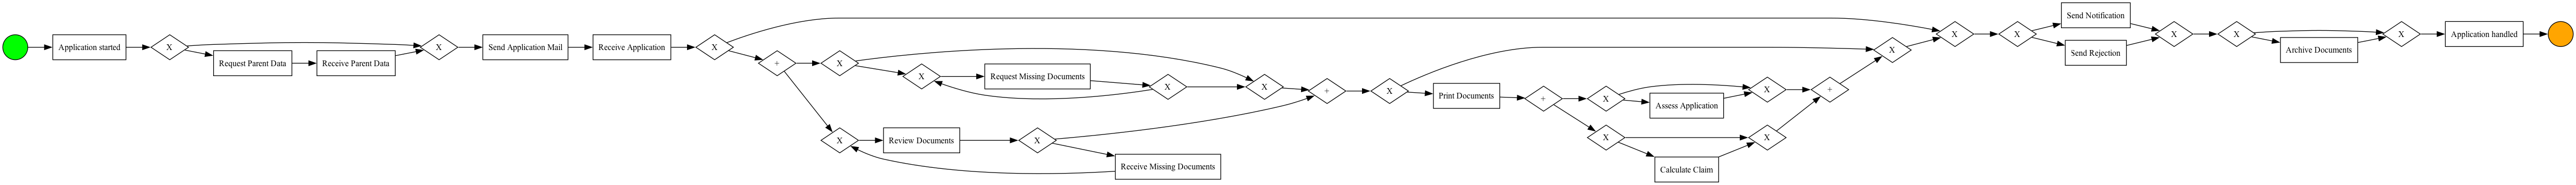

In [19]:
import pm4py
import graphviz

# 1. Daten vorbereiten (PM4Py erwartet spezifische Spaltennamen oder Parameter)
# Wir nutzen den bereits erstellten DataFrame 'df_events'
log_df = df_events.rename(columns={
    'case_id': 'case:concept:name',
    'activity': 'concept:name',
    'timestamp': 'time:timestamp'
}).copy()

# Convert timestamp to datetime
log_df['time:timestamp'] = pd.to_datetime(log_df['time:timestamp'])

# 2. Process Discovery (Inductive Miner ist robust und gut für Petri-Netze)
print("Mining BPMN Model...")
bpmn_model = pm4py.discover_bpmn_inductive(log_df)

# 3. Visualisierung
pm4py.view_bpmn(bpmn_model)

## 9. Statistics & Validation

<div style="border-left:6px solid #14B8A6; padding:12px 14px; border-radius:10px;">

### How to read the results

<span style="display:inline-block; padding:2px 10px; border-radius:999px; border:1px solid currentColor; font-size:12px;">Throughput</span>
<span style="display:inline-block; padding:2px 10px; border-radius:999px; border:1px solid currentColor; font-size:12px;">Backlog</span>
<span style="display:inline-block; padding:2px 10px; border-radius:999px; border:1px solid currentColor; font-size:12px;">Sanity Checks</span>

This section prints a few checks so you can quickly validate that the generated log looks realistic.

---

#### 1) Distributions (high-level sanity)

- **Application status**: Approved/Rejected/Pending counts
- **Parent independence**: validates `parent_data_required` probabilities
- **Document types**: validates document generation
- **Activity distribution**: event counts per activity (spot unexpected spikes)

---

#### 2) Throughput time (case duration)

Throughput is computed per case and shown as quantiles.

- If `include_start_event` and `include_end_event` are enabled:
  - `Application handled` − `Application started`
- Otherwise:
  - first event timestamp − last event timestamp per `case_id`

---

#### 3) Backlog indicator (Clerk waiting times)

- Non-zero waiting times indicate real queueing/backlogs.
- If waiting times are near zero, increase demand or reduce `resources.Clerk.capacity`.

</div>

In [20]:
# Create dfs dictionary from existing dataframes
dfs = {
    'ap licatrons': df_apps,
    'documents': df_docs,
    'eveeas': df_events
}

#  dfs dictionary from existing dataframes
dfs = {
    'applications': df_apps,
    'documents': df_docs,
    'events': df_events
}

# Application status distribution
status_counts = dfs['applications']['status'].value_counts()
print("Applisation dtatus Distrtion:")
status_counts = dfs['applications']['status'].value_counts()
print(f"\nApproval Rate: {status_counts.get('Approved', 0) / len(dfs['applications']) * 100:.1f}%")
print(f"(Expected: ~84% approved, ~16% rejected per LaTeX Section 3.3)")

print("\n" + "="*50)

# Deviation type distribution
print("\nDeviation Type Distribution:")
deviation_counts = dfs['applications']['deviation_type'].value_counts(dropna=False)
print(deviation_counts)
total_apps = len(dfs['applications'])
switched = deviation_counts.get('Switched', 0)
shortened = deviation_counts.get('Shortened', 0)
timeout = deviation_counts.get('Timeout', 0)
print(f"\nSwitched: {switched/total_apps*100:.1f}% (Expected: ~10%)")
print(f"Shortened: {shortened/total_apps*100:.1f}% (Expected: ~5%)")
print(f"Timeout: {timeout/total_apps*100:.1f}% (Expected: ~4%)")

print("\n" + "="*50)

# Parent independence
parent_counts = dfs['applications']['is_parent_independent'].value_counts()
print("\nParent Independence:")
print(parent_counts)
parent_ind_rate = parent_counts.get(True, 0) / len(dfs['applications']) * 100
print(f"Parent-Independent Rate: {parent_ind_rate:.1f}% (Expected: ~20% per LaTeX Section 3.1)")

print("\n" + "="*50)

# Document types
print("\nDocument Types:")
print(dfs['documents']['doc_type'].value_counts())

print("\n" + "="*50)

# Activity distribution
print("\nActivity Distribution:")
print(dfs['events'].groupby('activity').size().sort_values(ascending=False))

print("\n" + "="*50)

# Throughput time + backlog indicators
case_events = dfs['events'][['case_id', 'activity', 'timestamp']].copy()
case_events['timestamp'] = pd.to_datetime(case_events['timestamp'])

start_rows = case_events[case_events['activity'] == 'Application started'][['case_id', 'timestamp']].rename(columns={'timestamp': 'start_ts'})
end_rows = case_events[case_events['activity'] == 'Application handled'][['case_id', 'timestamp']].rename(columns={'timestamp': 'end_ts'})

if len(start_rows) == 0 or len(end_rows) == 0:
    # Fallback if start/end events are disabled: use first/last event per case
    first_last = case_events.sort_values(['case_id', 'timestamp']).groupby('case_id').agg(
        start_ts=('timestamp', 'min'),
        end_ts=('timestamp', 'max')
    ).reset_index()
    throughput = first_last
    print("\nNOTE: Start/end events are disabled or missing; throughput computed using first/last event per case.")
else:
    throughput = start_rows.merge(end_rows, on='case_id', how='inner')

throughput['throughput_days'] = (throughput['end_ts'] - throughput['start_ts']).dt.total_seconds() / (24 * 3600)
throughput['throughput_minutes'] = (throughput['end_ts'] - throughput['start_ts']).dt.total_seconds() / 60

print("\nThroughput time (days) quantiles:")
print(throughput['throughput_days'].quantile([0.5, 0.75, 0.9, 0.95, 0.99]).round(2))

print("\nThroughput time (minutes) quantiles:")
print(throughput['throughput_minutes'].quantile([0.5, 0.75, 0.9, 0.95, 0.99]).round(0))

# Estimate active processing time (excluding wait times)
# According to LaTeX: ~83 minutes active processing time
activities_cfg = config.get('activities', {})
active_time_estimate = sum([
    activities_cfg.get('Receive Application', {}).get('mean_minutes', 13),
    activities_cfg.get('Review Documents', {}).get('mean_minutes', 13),
    activities_cfg.get('Assess Application', {}).get('mean_minutes', 15),
    activities_cfg.get('Calculate Claim', {}).get('mean_minutes', 20),
    activities_cfg.get('Send Notification', {}).get('mean_minutes', 10),
])
print(f"\nExpected active processing time: ~{active_time_estimate} min (LaTeX: ~83 min)")

if hasattr(sim, 'waiting_times_minutes') and 'Clerk' in sim.waiting_times_minutes:
    waits = np.array(sim.waiting_times_minutes['Clerk'], dtype=float)
    if waits.size > 0:
        print("\nClerk queue waiting time (minutes):")
        print(f"  Avg: {waits.mean():.2f}")
        print(f"  P50: {np.percentile(waits, 50):.2f}")
        print(f"  P90: {np.percentile(waits, 90):.2f}")
        print(f"  P95: {np.percentile(waits, 95):.2f}")
        print(f"  P99: {np.percentile(waits, 99):.2f}")

print("\nNOTE: If Clerk waiting times are near zero, increase demand (reduce interarrival means / increase num_cases) or reduce Clerk capacity.")

Applisation dtatus Distrtion:

Approval Rate: 80.3%
(Expected: ~84% approved, ~16% rejected per LaTeX Section 3.3)


Deviation Type Distribution:
deviation_type
None              8803
Timeout            415
Shortened          285
Blind_Approval     196
Switched           101
Name: count, dtype: int64

Switched: 1.0% (Expected: ~10%)
Shortened: 2.9% (Expected: ~5%)
Timeout: 4.2% (Expected: ~4%)


Parent Independence:
is_parent_independent
False    7814
True     1986
Name: count, dtype: int64
Parent-Independent Rate: 20.3% (Expected: ~20% per LaTeX Section 3.1)


Document Types:
doc_type
Formblatt 1                      9800
Immatrikulationsbescheinigung    9800
Formblatt 3                      7814
Einkommensnachweis Eltern        7814
Mietbescheinigung                5020
Name: count, dtype: int64


Activity Distribution:
activity
Review Documents             14551
Application handled           9800
Application started           9800
Receive Application           9800
Send Application 

## 10. Celonis Import Instructions

To import in Celonis:

1. **Upload Files**: Upload all 4 CSV files to a Celonis Data Pool

2. **Create Data Model**:
   - Activity Table: `events.csv`
     - Case Key: Link via `event_object_link` → `applications`
     - Activity: `activity`
     - Timestamp: `timestamp`
     - Sorting: `sorting_integer`
   
3. **Object Tables**:
   - `applications.csv` - Primary object
   - `documents.csv` - Secondary object (linked via `application_id`)

4. **Link Table**: `event_object_link.csv`
   - Links events to both Application and Document objects

5. **Foreign Keys**:
   - `documents.application_id` → `applications.application_id`
   - `event_object_link.event_id` → `events.event_id`
   - `event_object_link.object_id` → `applications.application_id` (when object_type = 'Application')
   - `event_object_link.object_id` → `documents.document_id` (when object_type = 'Document')